In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from src.leachSFtree import leachSFClusteringJoin, leachSFClusteringTreeJoin
from src.mst_prim import prim_mst, create_routes_dict
import src.util as util
import src.topology as topology
import networkx as nx
from src.nova_join import Operator, OperatorType, NovaSolver
from src.util import log_opt_label, coordinator_label, worker_label, centroid_label, ch_label, join_label
from src.cardinalities import create_cardinalities, create_adjacency_matrix, create_unique_n_tuples, \
    create_adjacency_matrix_from_pairs, generate_random_integer_dict
from src.util import evaluate_graph, evaluate_routes, plot_distributions_pdf
from src.topology import transition_uniform_to_exponential, create_topologies_from_dict
from src.baselines import sink_based_placement, source_based_placement, top_c
from src.eval_tools import *

### Topology Setup

In [2]:
seed = 10

worker_capacity = (1, 200)
source_capacity = (1, 50)
source_frac = 0.6
coord_cols = ["x", "y"]

X_dim = [-600, 600]
Y_dim = [-600, 700]
centers = 10
clustering = False

eval_matrix = {}

In [3]:
t_label = "king"
coord_dict = {t_label: topology.coords_KING()}
device_number = coord_dict[t_label].shape[0]

In [4]:
prim_df, base_col, capacity_columns = \
create_topologies_from_dict(coord_dict, coord_cols, worker_capacity=worker_capacity,
                            source_capacity=source_capacity, source_frac=source_frac, with_clustering=clustering,
                            seed=seed)[t_label]

eval_columns = [base_col] + capacity_columns
opt_k = prim_df["cluster"].nunique()
num_sources = prim_df[prim_df["type"] == "SOURCE"].shape[0]
num_workers = prim_df[prim_df["type"] == "WORKER"].shape[0]
num_sinks = prim_df[prim_df["type"] == "SINK"].shape[0]
sink_indices = prim_df[prim_df["type"] == "SINK"].index.tolist()
coord_dict = prim_df[coord_cols].apply(list, axis=1).to_dict()

print(f"n={prim_df.shape[0]}, sinks={num_sinks}, workers={num_workers}, sources={num_sources}")
prim_df.head(10)

Creating df for king
Done
n=1740, sinks=1, workers=695, sources=1044


x    y  cluster     latency    type  capacity_inf  capacity_0  capacity_1  \
0  20 -279        0    0.000000    SINK       9999999         100         100   
1  26  -17        0  262.068693  SOURCE       9999999          38          29   
2  19  -14        0  265.001887  SOURCE       9999999           2           6   
3  53   -2        0  278.958778  SOURCE       9999999          32          22   
4  28  -15        0  264.121184  SOURCE       9999999          37          27   
5  32    3        0  282.255204  SOURCE       9999999          25          22   
6  35    1        0  280.401498  SOURCE       9999999          12          25   
7  -3   10        0  289.913780  SOURCE       9999999          10          19   
8  10   -5        0  274.182421  SOURCE       9999999          38          38   
9  -6   29        0  309.095455  SOURCE       9999999           9           6   

   capacity_2  capacity_3  capacity_4  capacity_5  
0         100         100         100         100  
1          24          20          16          12  
2           8          10          12          13  
3          16          11           7           3  
4          21          16          11           7  
5          20          18          16          15  
6          33          39          45          50  
7          24          29          32          36  
8          38          38          38          38  
9           4           2           1           0

Total: Step 0 -> Sum: 93324, Mean: 53.67, Median: 35.00, Min: 1.00, Max: 199.00
Total: Step 1 -> Sum: 93314, Mean: 53.66, Median: 33.00, Min: 1.00, Max: 316.00
Total: Step 2 -> Sum: 93317, Mean: 53.66, Median: 32.00, Min: 0.00, Max: 410.00
Total: Step 3 -> Sum: 93341, Mean: 53.68, Median: 33.00, Min: 0.00, Max: 489.00
Total: Step 4 -> Sum: 93335, Mean: 53.67, Median: 30.00, Min: 0.00, Max: 559.00
Total: Step 5 -> Sum: 93300, Mean: 53.65, Median: 27.00, Min: 0.00, Max: 624.00
SOURCE: Step 0 -> Sum: 25659, Mean: 24.58, Median: 24.50, Min: 1.00, Max: 49.00
SOURCE: Step 1 -> Sum: 25666, Mean: 24.58, Median: 24.00, Min: 1.00, Max: 125.00
SOURCE: Step 2 -> Sum: 25655, Mean: 24.57, Median: 22.00, Min: 0.00, Max: 171.00
SOURCE: Step 3 -> Sum: 25670, Mean: 24.59, Median: 20.00, Min: 0.00, Max: 210.00
SOURCE: Step 4 -> Sum: 25663, Mean: 24.58, Median: 18.00, Min: 0.00, Max: 244.00
SOURCE: Step 5 -> Sum: 25628, Mean: 24.55, Median: 17.00, Min: 0.00, Max: 275.00
Total Mean: 53


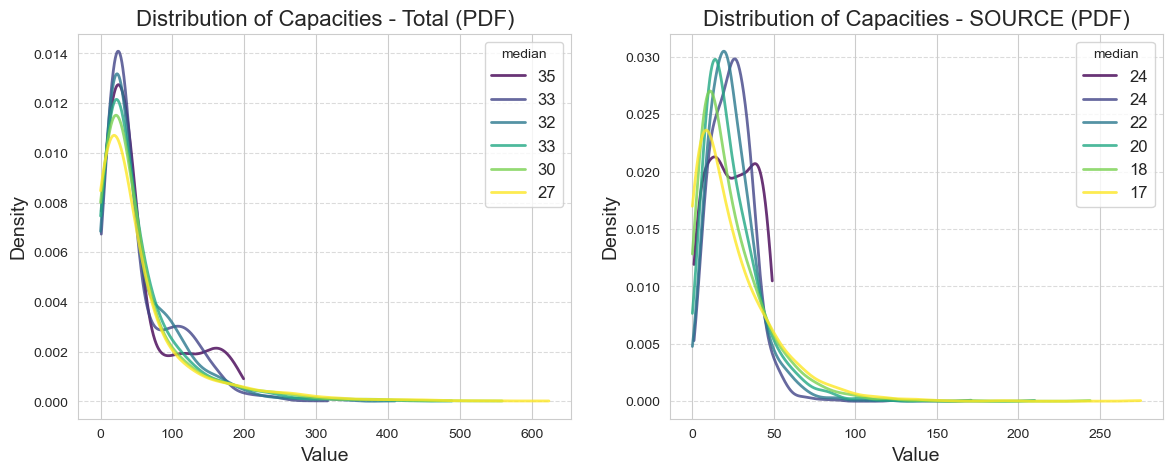

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Display the total distributions
distributions = []
medians = []
total_mean = []
sum_capacities = 0
for i, col in enumerate(capacity_columns):
    dist = prim_df[prim_df["type"] != "SINK"][col].to_numpy()
    distributions.append(dist)
    medians.append(np.median(dist))
    total_mean.append(np.mean(dist))
    sum_capacities += np.sum(dist)
    print(f"Total: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
sum_capacities = sum_capacities // len(distributions)
# Plot the PDFs
dist_colors = plt.cm.viridis(np.linspace(0, 1, len(distributions)))
plot_distributions_pdf(axes[0], distributions, dist_colors)
axes[0].set_title('Distribution of Capacities - Total (PDF)', fontsize=16)

# Display the individual distributions
for cnt_idx, type in enumerate(["SOURCE"]):
    dist_type = []
    for i, col in enumerate(capacity_columns):
        dist = prim_df[prim_df["type"] == type][col].to_numpy()
        dist_type.append(dist)
        print(f"{type}: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
    # Plot the PDFs
    dist_colors = plt.cm.viridis(np.linspace(0, 1, len(dist_type)))
    plot_distributions_pdf(axes[cnt_idx+1], dist_type, dist_colors)
    axes[cnt_idx+1].set_title(f'Distribution of Capacities - {type} (PDF)', fontsize=16)

total_mean = int(np.mean(total_mean))
print("Total Mean:", total_mean)

plt.savefig("plots/king/king_{0}_capacity_dist.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [6]:
colors, colors_hex, light_colors = util.get_color_list(opt_k)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

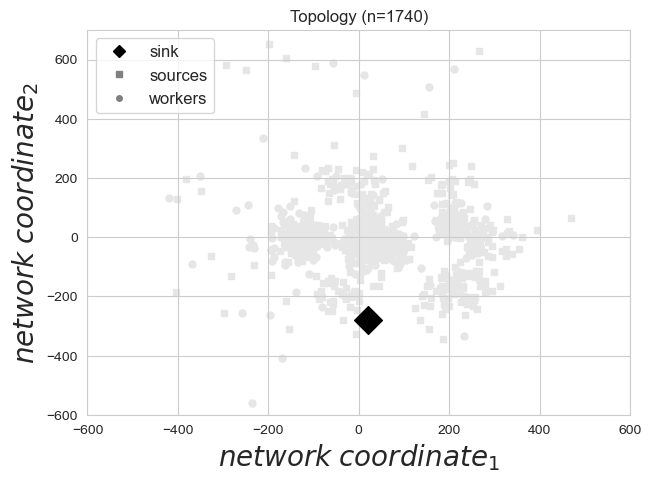

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=True, show_coordinator=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/king/king_{0}_ncs.svg".format(str(device_number)), bbox_inches="tight")

plt.title(f"Topology (n={device_number})")

plt.show()

### Create Join Matrix

In [8]:
# Create a list of labels for the index and columns
source_indices = list(prim_df[prim_df["type"] == "SOURCE"].index.values)
sink_capacity = len(source_indices) * 5
input_range = [1, 75]
output_range = [1, 200]
total_sum_sources = (np.mean(input_range) * num_sources)
prim_df.loc[prim_df[prim_df["type"] == "SINK"].index, capacity_columns] = sink_capacity + 0.2*sink_capacity
print(
    f"Sources={len(source_indices)}, Sum capacities={sum_capacities}; Sum load sources={total_sum_sources}; Sum load output={sink_capacity}")

source_cardinalities = generate_random_integer_dict(source_indices, total_sum_sources, input_range[0], input_range[1],
                                                    seed=seed)
join_pairs, unassigned = create_unique_n_tuples(source_indices, 2, shuffle=False)
join_matrix_df, join_matrix, required = create_adjacency_matrix_from_pairs(prim_df.shape[0], join_pairs, output_range,
                                                           output_sum=sink_capacity, seed=seed)
print(f"Required resources for sinks:{required}")
join_matrix_df.head(10)

Sources=1044, Sum capacities=93321; Sum load sources=39672.0; Sum load output=5220
Generating n=1044 random integers between 1 and 75, sum=39672.0
Generating n=522 random integers between 1 and 200, sum=5220
Required resources for sinks:5220


0     1     2     3     4     5     6     7     8     9     10    11    \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     1     0     0     0     0     0     0     0     0     0   
2     0     1     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     1     0     0     0     0     0     0     0   
4     0     0     0     1     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0    13     0     0     0     0     0   
6     0     0     0     0     0    13     0     0     0     0     0     0   
7     0     0     0     0     0     0     0     0     1     0     0     0   
8     0     0     0     0     0     0     0     1     0     0     0     0   
9     0     0     0     0     0     0     0     0     0     0     1     0   

   12    13    14    15    16    17    18    19    20    21    22    23    \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0     0     0     0     0     0     0   
6     0     0     0     0     0     0     0     0     0     0     0     0   
7     0     0     0     0     0     0     0     0     0     0     0     0   
8     0     0     0     0     0     0     0     0     0     0     0     0   
9     0     0     0     0     0     0     0     0     0     0     0     0   

   24    25    26    27    28    29    30    31    32    33    34    35    \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0     0     0     0     0     0     0   
6     0     0     0     0     0     0     0     0     0     0     0     0   
7     0     0     0     0     0     0     0     0     0     0     0     0   
8     0     0     0     0     0     0     0     0     0     0     0     0   
9     0     0     0     0     0     0     0     0     0     0     0     0   

   36    37    38    39    40    41    42    43    44    45    46    47    \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0     0     0     0     0     0     0   
6     0     0     0     0     0     0     0     0     0     0     0     0   
7     0     0     0     0     0     0     0     0     0     0     0     0   
8     0     0     0     0     0     0     0     0     0     0     0     0   
9     0     0     0     0     0     0     0     0     0     0     0     0   

   48    49    50    51    52    53    54    55    56    57    58    59    \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   
5     0     0     0     0     0     0     0     0     0     0     0     0   
6     0     0     0     0     0     0     0     0     0     0     0     

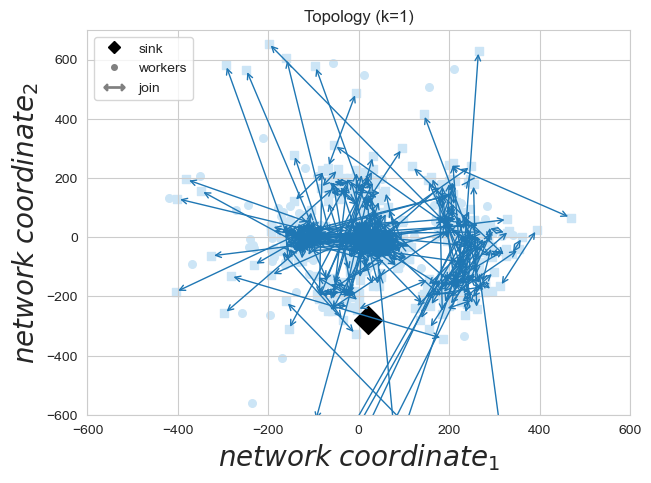

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

for i, j in join_pairs:
    if join_matrix[i, j] > 0:
        point1 = prim_df.iloc[i][coord_cols].to_numpy()
        point2 = prim_df.iloc[j][coord_cols].to_numpy()
        cluster = prim_df.loc[i, "cluster"]
        # print(i, j, point1, point2)
        arrow = FancyArrowPatch(point1, point2, arrowstyle='<->', mutation_scale=10, color=colors[cluster], linewidth=1)
        ax1.add_patch(arrow)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, worker_label, join_label]
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(0, 1), prop={'size': 10})

plt.savefig(f"plots/king/king_{device_number}_ncs_grouped_{source_frac}.svg", bbox_inches="tight")

plt.show()

### Create Logical Plan

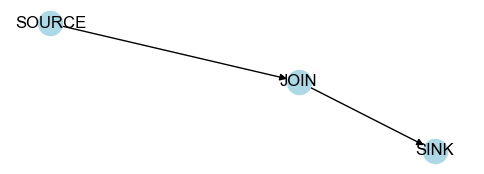

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=OperatorType.SOURCE)
logical_plan.add_node(2, type=OperatorType.JOIN)
logical_plan.add_node(3, type=OperatorType.SINK)

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 2, 1), (2, 3, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog='neato')
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='lightblue')

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

# Show the plot
plt.show()

## Perform Placement

### Nova

In [11]:
reduction_fac=0.4
cardinality_dict = {1: source_cardinalities, 2: (join_matrix, join_pairs)}

df_stats = None
nova_placements = {}

In [12]:
for capacity_col in eval_columns: #[eval_columns[2]]:
    print("Starting nova placement for", capacity_col)
    pdf = prim_df.copy()

    if capacity_col == base_col:
        nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      knn_neighbors=2, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False, pre_knn=False)
    else:
        nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      knn_radius=250, k_resources=prim_df[capacity_col].median()//2, capacity_col=capacity_col, use_weight=False, pre_knn=False)

    df_nova_it, rep_plan_it, rel_positions_it, placement_it = nova.nova_full()

    nova_placements[capacity_col] = df_nova_it, rep_plan_it, rel_positions_it, placement_it
    df_stats_it = evaluate_graph(df_nova_it, rep_plan_it)
    eval_matrix["nova_" + capacity_col] = df_stats_it.copy()

Starting nova placement for capacity_inf
Initializing Nova for 1740
Running Nova on capacity_inf
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=1567 nodes
Relaxed positions: 1567
Replicas for 1:1044
Replication count for upstream operators to 1 -> 0
Replicas for 2:522
Distributing load: operator_id=1741, opt=[21.663033436851933, -103.66423023651792], upstream_nodes=([np.int64(1), np.int64(2)])
Left=10, right=16, batches=8, batch_factor=0.4, batch_threshold=5.0, required=72, part_req=10 resource_limit=4999999.0, neighbor_size=2
Searching knn [21.663033436851933, -103.66423023651792] 1739 2 2 0
Distributing finished: operator_id=1741 (1, 2) to n=1, opt=[21.663033436851933, -103.66423023651792], upstream_nodes=[1548], additional load=0.0
Distributing load: operator_id=1742, opt=[33.64878752453481, -98.991973322553], upstream_nodes=([np.int64(3), np.int64(4)])
Left=71, right=31, batches=8, batch_facto

In [13]:
for k, vals in nova_placements.items():
    df_nova, rep_plan_nova, rel_positions_nova, placement_nova = vals
    if df_nova[df_nova["free_capacity"] < 0].shape[0] > 0:
        print(f"Overloaded: {k}->{df_nova[df_nova['free_capacity'] < 0].shape[0]}")

In [14]:
plot_col = eval_columns[2]
df_nova, rep_plan_nova, rel_positions_nova, placement_nova = nova_placements[plot_col]

In [15]:
df_nova.head(10)

x    y    type  unbalanced  weight  real_weight  total_capacity  \
0  20 -279    SINK           0       0            0            6264   
1  26  -17  SOURCE           0      10           10              29   
2  19  -14  SOURCE           0      16           16               6   
3  53   -2  SOURCE           0      71           71              22   
4  28  -15  SOURCE           0      31           31              27   
5  32    3  SOURCE           0      30           30              22   
6  35    1  SOURCE           0      10           10              25   
7  -3   10  SOURCE           0      75           75              19   
8  10   -5  SOURCE           0       2            2              38   
9  -6   29  SOURCE           0      41           41               6   

   free_capacity  level        parent  
0        1020.16      2            []  
1          29.00      0  [(1149, 10)]  
2           6.00      0  [(1149, 16)]  
3          22.00      0  [(1149, 71)]  
4          27.00      0  [(1149, 31)]  
5          22.00      0  [(1360, 30)]  
6          25.00      0  [(1360, 10)]  
7          19.00      0  [(1245, 75)]  
8          38.00      0   [(1245, 2)]  
9           6.00      0  [(1646, 41)]

In [16]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5'])

#### Replication Plan

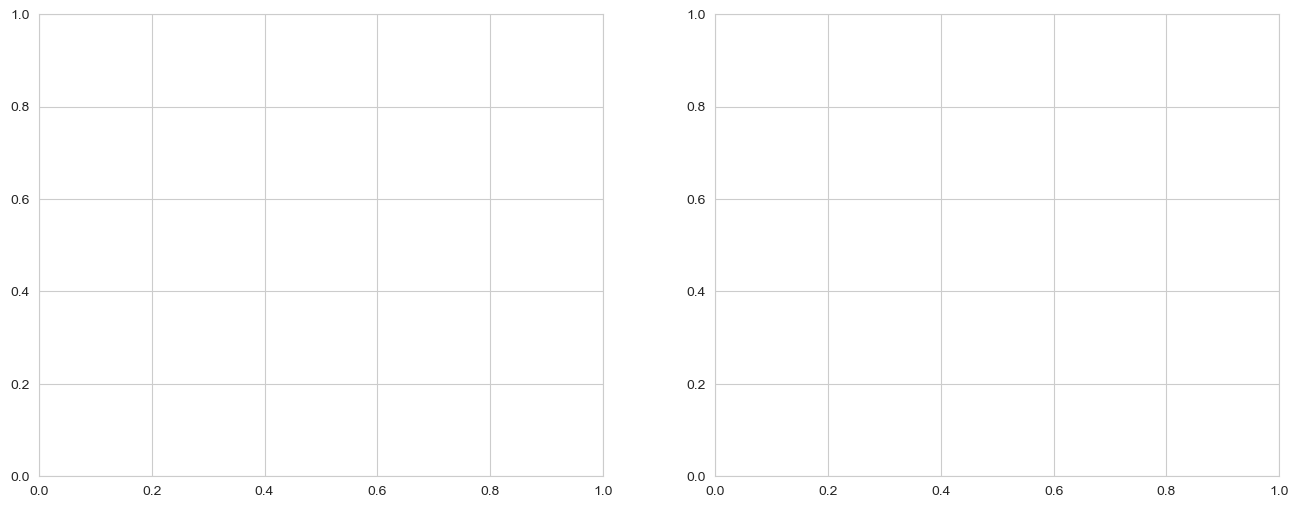

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i_ax, edge_type in enumerate(["distance", "cardinality"]):
    if num_sources > 100:
        break
    # Draw the graph
    pos = nx.nx_agraph.graphviz_layout(rep_plan_nova, prog='neato')
    nx.draw(rep_plan_nova, pos, ax=axs[i_ax], with_labels=False, arrows=True, node_color='lightblue')

    # Extract and draw node labels
    node_labels = nx.get_node_attributes(rep_plan_nova, 'type')
    nx.draw_networkx_labels(rep_plan_nova, pos, ax=axs[i_ax], labels=node_labels)

    # Extract and draw edge labels based on edge attributes
    edge_labels = nx.get_edge_attributes(rep_plan_nova, edge_type)  # Replace 'attribute_name' with your edge attribute key
    nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs[i_ax], edge_labels=edge_labels)
    axs[i_ax].set_title("Replication Plan: " + edge_type)

# Show the plot
plt.show()

#### Placement

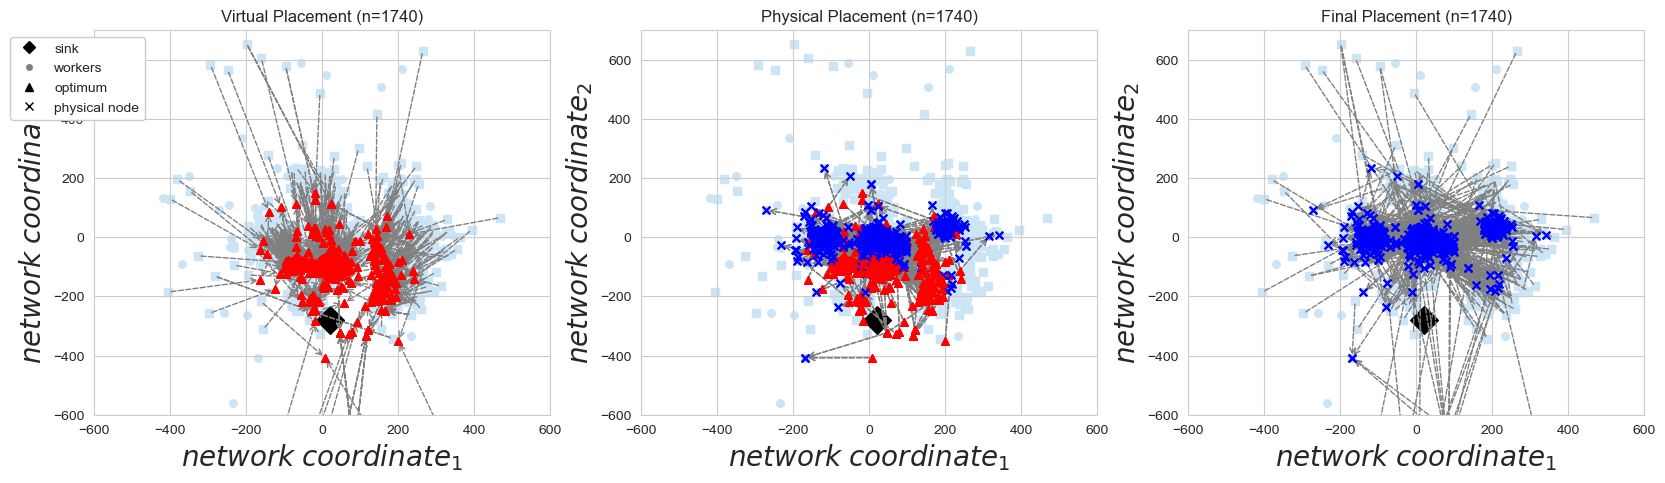

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax1, ax2, ax3 = axs
df_nova["cluster"] = 0

# resolve the placement
placement_coords = dict()
for key, val in placement_nova.items():
    placement_coords[key] = df_nova.loc[val, coord_cols].to_numpy()

ax1 = util.plot_topology(ax1, df_nova, colors=colors, title='Virtual Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax2 = util.plot_topology(ax2, df_nova, colors=colors, title='Physical Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax3 = util.plot_topology(ax3, df_nova, colors=colors, title='Final Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)

for n1, n2 in rep_plan_nova.edges:
    if n2 not in df_nova.index:
        # plot the logical nodes
        ax1.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)
        ax2.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)

        # plot the physical nodes
        ax2.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)
        ax3.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)

    if n2 in df_nova.index:
        # arrow to the sink
        #arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="-", mutation_scale=10, color="grey", linewidth=1)
        #ax3.add_patch(arrow)
        continue
    else:
        color = "grey"
        # physical nodes -> virtual nodes
        arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax1.add_patch(arrow)
        #arrow = FancyArrowPatch(rel_positions[n1], rel_positions[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color=color, linewidth=1)
        #ax2.add_patch(arrow)
        # virtual node -> physical node
        arrow = FancyArrowPatch(rel_positions_nova[n2], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax2.add_patch(arrow)
        arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax3.add_patch(arrow)

    #arrow = FancyArrowPatch(placement[n1], placement[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color="grey", linewidth=1)
    #ax3.add_patch(arrow)

handles = [coordinator_label, worker_label, log_opt_label, ch_label]
ax3.get_legend().remove()
ax2.get_legend().remove()
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(-0.2, 1), prop={'size': 10}, framealpha=1)

for ax in axs:
    ax.set_xlim(X_dim)
    ax.set_ylim(Y_dim)

plt.savefig(f"plots/king/king_{device_number}_nova_complete_{source_frac}.svg", bbox_inches="tight")
plt.show()

## Baselines

### Experiment 1: Sink-based - Placement at the Sink


In [19]:
df_stats = sink_based_placement(coord_dict, sink_indices, join_pairs, source_cardinalities)
eval_matrix["sink-based"] = df_stats.copy()
df_stats.head()

latency_distribution  received_packets
0                   0.0           39672.0
1                 262.0               0.0
2                 265.0               0.0
3                 278.0               0.0
4                 264.0               0.0

### Experiment 2: Source-based - Placement at the Sources

In [20]:
df_stats = source_based_placement(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities)
eval_matrix["source-based"] = df_stats.copy()

In [21]:
df_stats.head()

latency_distribution  received_packets
0                   0.0            5220.0
1                 272.0               0.0
2                 265.0              10.0
3                 278.0              31.0
4                 306.0               0.0

### Experiment 3: Top-C - Placement at Highest Capacity Nodes

In [22]:
for capacity_col in eval_columns:
    df_stats = top_c(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities, capacity_col)
    eval_matrix["top-c_" + capacity_col] = df_stats.copy()
df_stats.head()

latency_distribution  received_packets
0                   0.0            5220.0
1                 316.0               0.0
2                 313.0               0.0
3                 325.0               0.0
4                 315.0               0.0

### Experiment 3: Tree - Placement at intersections 

In [23]:
mst_coords = prim_df[coord_cols].apply(lambda row: tuple(row), axis=1).to_dict()
mst = prim_mst(mst_coords, root=0)
routes = create_routes_dict(mst)

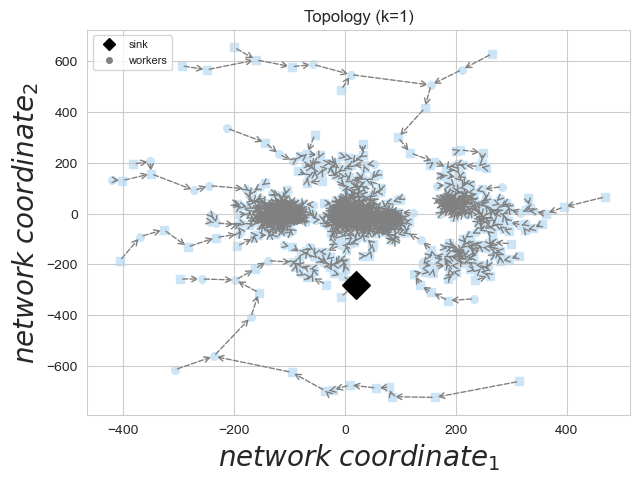

In [24]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
edge_color = "grey"

for node, parent in mst.items():
    point1 = prim_df.loc[node, coord_cols].to_numpy()
    point2 = prim_df.loc[parent, coord_cols].to_numpy()
    arrow = FancyArrowPatch(point1, point2, arrowstyle='->', linestyle="--", mutation_scale=10, color=edge_color,
                            linewidth=1)
    ax1.add_patch(arrow)

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/king/king_{0}_mst.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [25]:
df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
eval_matrix["tree"] = df_stats.copy()
df_stats.head()

latency_distribution  received_packets
0              0.000000           10589.0
1            385.816139            9045.0
2            405.181198             144.0
3            448.742141               0.0
4            388.644566            9223.0

### Clustering - Placement at intersecting Centroids

In [26]:
num_leach_clusters = max(4, int(0.1 * device_number))

df_cl_join = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_cl_join, ch_indices, centers, u = leachSFClusteringJoin(df, capacity_col, num_leach_clusters)
    # evaluation
    routes = df_cl_join["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
    eval_matrix["cl-sf_" + capacity_col] = df_stats.copy()

In [27]:
df_cl_join.head()

oindex   x    y    type  cluster  capacity_5  parent     route  level
0       0  20 -279    SINK       -1        6264     NaN        []      2
1       1  26  -17  SOURCE       73          12   573.0  [573, 0]      0
2       2  19  -14  SOURCE       57          13   326.0  [326, 0]      0
3       3  53   -2  SOURCE       13           3     0.0       [0]      1
4       4  28  -15  SOURCE       73           7   573.0  [573, 0]      0

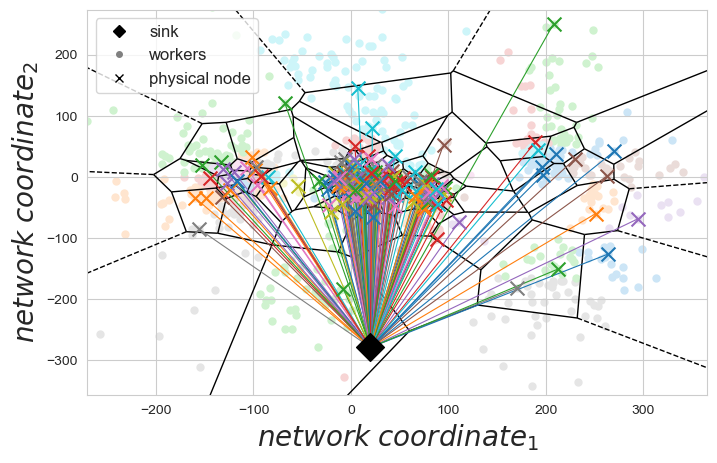

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_cl_join, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/king/king_{0}_clustering.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [29]:
df_stats.head()

latency_distribution  received_packets
0              0.000000           37756.0
1            264.507353               0.0
2            268.007547               0.0
3            278.958778              66.0
4            264.507353               0.0

### Clustering+Tree - Placement at Intersecting Trees

In [30]:
num_leach_clusters = max(4, int(0.1 * device_number))
df_clTree = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_clTree, ch_indices, centers, u = leachSFClusteringTreeJoin(df, capacity_col, num_leach_clusters, coord_cols)

    # evaluation
    routes = df_clTree["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
    eval_matrix["cl-tree-sf_" + capacity_col] = df_stats.copy()

In [31]:
df_clTree.head()

oindex   x    y    type  cluster  capacity_5  parent  \
0       0  20 -279    SINK       -1        6264     NaN   
1       1  26  -17  SOURCE       50          12   573.0   
2       2  19  -14  SOURCE       41          13   610.0   
3       3  53   -2  SOURCE       95           3  1164.0   
4       4  28  -15  SOURCE       50           7   573.0   

                                                                                                                                                                          route  \
0                                                                                                                                                                            []   
1                                                  [573, 326, 610, 1585, 598, 1519, 1607, 278, 105, 973, 613, 256, 1102, 592, 967, 1201, 1580, 100, 1010, 61, 928, 653, 628, 0]   
2                                                            [610, 1585, 598, 1519, 1607, 278, 105, 973, 613, 256, 1102, 592, 967, 1201, 1580, 100, 1010, 61, 928, 653, 628, 0]   
3  [1164, 267, 1154, 907, 1532, 97, 995, 1576, 114, 573, 326, 610, 1585, 598, 1519, 1607, 278, 105, 973, 613, 256, 1102, 592, 967, 1201, 1580, 100, 1010, 61, 928, 653, 628, 0]   
4                                                  [573, 326, 610, 1585, 598, 1519, 1607, 278, 105, 973, 613, 256, 1102, 592, 967, 1201, 1580, 100, 1010, 61, 928, 653, 628, 0]   

   level  
0     48  
1     24  
2     26  
3     15  
4     24

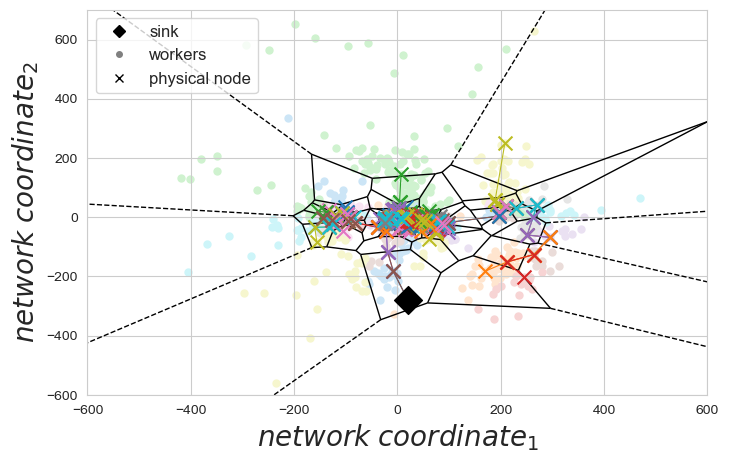

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_clTree, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/king/king_{0}_clustering_tree.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [33]:
df_stats.head()

latency_distribution  received_packets
0              0.000000           10462.0
1            368.828957               0.0
2            359.320686               0.0
3            416.030508               0.0
4            368.828957               0.0

## Evaluation

In [34]:
homogeneous = ['sink-based', 'source-based', 'tree']
heterogeneous = ["cl-sf", "cl-tree-sf", "top-c"] + ["nova"]

In [35]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

### Latency

In [36]:
approach_order = get_approaches()
eval_colors = get_eval_colors_dict()
markers = get_markers_dict()
styles = get_styles_dict()

sink-based sink-based
source-based source-based
top-c top-c_capacity_inf
tree tree
cl-sf cl-sf_capacity_inf
cl-tree-sf cl-tree-sf_capacity_inf
nova nova_capacity_inf
nova (p) nova_capacity_5


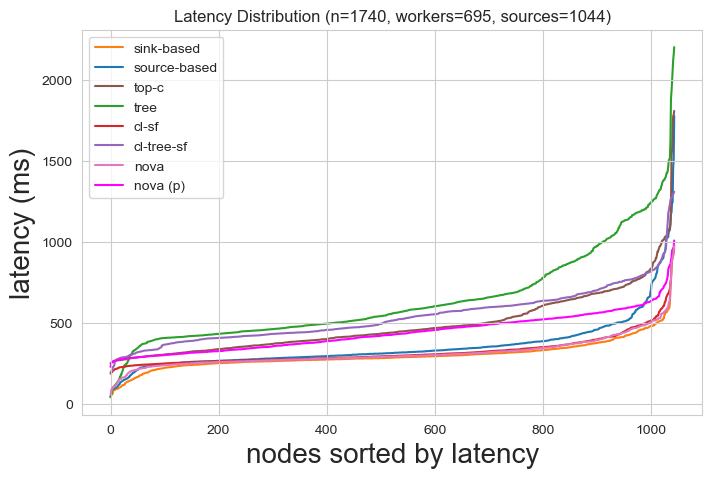

Means:  {'sink-based': np.float64(300.18), 'source-based': np.float64(354.85), 'top-c': np.float64(487.33), 'tree': np.float64(639.63), 'cl-sf': np.float64(322.48), 'cl-tree-sf': np.float64(536.22), 'nova': np.float64(313.5), 'nova (p)': np.float64(439.01)}
Quantiles:  {'sink-based': np.float64(408.0), 'source-based': np.float64(501.7), 'top-c': np.float64(711.7), 'tree': np.float64(1072.49), 'cl-sf': np.float64(427.03), 'cl-tree-sf': np.float64(747.81), 'nova': np.float64(430.0), 'nova (p)': np.float64(583.0)}


In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
eval_labels = []
for label in approach_order:
    if label in heterogeneous:
        eval_labels.append((label, label + "_" + eval_columns[0]))
        if label.startswith("nova"):
            eval_labels.append((label + " (p)", label + "_" + eval_columns[-1]))
    else:
        eval_labels.append((label, label))

#plot baselines
for label, eval_col in eval_labels:
    print(label, eval_col)
    eval_df = eval_matrix[eval_col]["latency_distribution"][eval_matrix[eval_col]["latency_distribution"] > 0]
    sv = eval_df.sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[label] = round(eval_df.quantile(0.9), 2)
    mean_dict[label] = round(eval_df.mean(), 2)
    if label == "nova":
        zorder = 100
    else:
        zorder = 0
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=label, color=eval_colors[label], zorder=zorder)

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/king/king_{0}_eval_latency.svg".format(str(device_number)), bbox_inches="tight")

ax1.set_title(f'Latency Distribution (n={device_number}, workers={num_workers}, sources={num_sources})')
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

### Heterogeneity

In [38]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

In [39]:
load_dict = {}
load_norm_dict = {}
nn_dict = {}

for k in approach_order:
    slot_list = []
    slot_list_norm = []
    nn_list = []
    for colname in capacity_columns:
        if k in homogeneous:
            df = eval_matrix_load[k]
        else:
            df = eval_matrix_load[k + "_" + colname]
        df["av_capacity"] = prim_df[colname] - df["received_packets"]
        agg_nodes = df["received_packets"][df["received_packets"] > 0].count()
        tmp_df_sl = df[df["av_capacity"] < 0]
        tmp_df_nn = df[df["av_capacity"] >= 0]
        slot_list.append(tmp_df_sl["av_capacity"].count())
        slot_list_norm.append(int((tmp_df_sl["av_capacity"].count() / agg_nodes) * 100))
        nn_list.append(tmp_df_nn["av_capacity"].count())
    load_dict[k] = slot_list
    load_norm_dict[k] = slot_list_norm
    nn_dict[k] = nn_list

In [40]:
load_dict.keys()

dict_keys(['sink-based', 'source-based', 'top-c', 'tree', 'cl-sf', 'cl-tree-sf', 'nova'])

In [41]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
    print(load_norm_dict[fam])

Fam:  sink-based
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[100, 100, 100, 100, 100, 100]
Fam:  source-based
[np.int64(261), np.int64(255), np.int64(260), np.int64(270), np.int64(284), np.int64(296)]
[49, 48, 49, 51, 54, 56]
Fam:  top-c
[np.int64(46), np.int64(61), np.int64(69), np.int64(53), np.int64(31), np.int64(21)]
[12, 14, 18, 16, 10, 7]
Fam:  tree
[np.int64(1037), np.int64(1042), np.int64(1045), np.int64(1051), np.int64(1046), np.int64(1060)]
[86, 86, 86, 87, 87, 88]
Fam:  cl-sf
[np.int64(148), np.int64(143), np.int64(144), np.int64(145), np.int64(149), np.int64(153)]
[92, 89, 91, 92, 93, 96]
Fam:  cl-tree-sf
[np.int64(170), np.int64(168), np.int64(167), np.int64(170), np.int64(170), np.int64(171)]
[98, 98, 97, 98, 98, 99]
Fam:  nova
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[0, 0, 0, 0, 0, 0]


sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [np.int64(261), np.int64(255), np.int64(260), np.int64(270), np.int64(284), np.int64(296)]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [np.int64(46), np.int64(61), np.int64(69), np.int64(53), np.int64(31), np.int64(21)]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [np.int64(1037), np.int64(1042), np.int64(1045), np.int64(1051), np.int64(1046), np.int64(1060)]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [np.int64(148), np.int64(143), np.int64(144), np.int64(145), np.int64(149), np.int64(153)]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [np.int64(170), np.int64(168), np.int64(167), np.int64(170), np.int64(170), np.int64(171)]
nova (0, (3, 1, 1

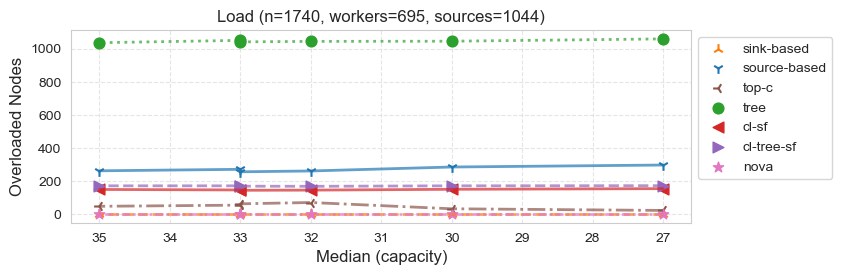

In [42]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 2.5))

medians_plot = medians

for fam in load_dict.keys():
    vals = load_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Nodes", fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/king/king_{device_number}_eval_load_abs_{source_frac}.svg", bbox_inches="tight")
ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [100, 100, 100, 100, 100, 100]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [49, 48, 49, 51, 54, 56]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [12, 14, 18, 16, 10, 7]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [86, 86, 86, 87, 87, 88]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [92, 89, 91, 92, 93, 96]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [98, 98, 97, 98, 98, 99]
nova (0, (3, 1, 1, 1)) * (0.8901960784313725, 0.4666666666666667, 0.7607843137254902) : [0, 0, 0, 0, 0, 0]


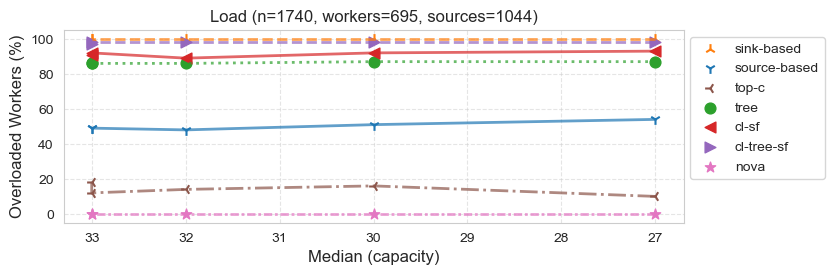

In [47]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 2.5))

medians_plot = medians[1:]

for fam in load_norm_dict.keys():
    vals = load_norm_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Workers (%)", fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/king/king_{device_number}_eval_load_perc_{source_frac}.svg", bbox_inches="tight")

ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

In [45]:
mean_dict

{'sink-based': np.float64(300.18),
 'source-based': np.float64(354.85),
 'top-c': np.float64(487.33),
 'tree': np.float64(639.63),
 'cl-sf': np.float64(322.48),
 'cl-tree-sf': np.float64(536.22),
 'nova': np.float64(313.5),
 'nova (p)': np.float64(439.01)}

In [46]:
quant_dict

{'sink-based': np.float64(408.0),
 'source-based': np.float64(501.7),
 'top-c': np.float64(711.7),
 'tree': np.float64(1072.49),
 'cl-sf': np.float64(427.03),
 'cl-tree-sf': np.float64(747.81),
 'nova': np.float64(430.0),
 'nova (p)': np.float64(583.0)}